# Cats vs Dogs Classifier

## Importing libraries
The following code cell imports essential libraries for data analysis and visualization:

- `pandas` for data manipulation and analysis.
- `numpy` for numerical operations.
- `matplotlib.pyplot` and `seaborn` for data visualization.
- `warnings` to suppress warning messages for cleaner output.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


## Importing dataset directly from Kaggle
The following code cell is crucial for importing Kaggle data sources into the correct location (`/kaggle/input`) within your notebook. This is necessary due to the differences between this notebook environment and Kaggle's Python environment, which may result in missing libraries. Feel free to delete this cell after running it.


In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'dogs-vs-cats:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3362%2F31148%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240728%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240728T205605Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7151dfec799b68d0459916cd57fa0e347393fd975cde0a154b5c85e817df282d771b3eeda6d732c3e394314d52ca6b3f3ec16910918fb528d1fd3a9477e1e0d40037dce707c7eda4d652465203069728f2fb37b9b1cbbc2ac49c708bf7808992b37235686df07894e8fe63d53e9a09635134aa273f9de1e217af763463431593cd662b66c90fb39c341d8889c0bb77fb9919926a04d5efe146b9744306d6b0f7eabc8e0350eaf2538d240bb357ca36200c235d6f7b9179f7452a13d867202312cc4660c673665be4b21339c028f15a91d43d3909f22d76f67b858b3101553d533dd0b903b3b224ef8584efb436aade8d519b209e4f813753e9f88915a8ddfde2'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 851576689 bytes downloaded
Downloaded and uncompressed: dogs-vs-cats
Data source import complete.


## Checking Dataset
This code cell lists the contents of the `../input` directory, which is where the Kaggle data sources are imported. Running this cell will help verify that the data has been successfully downloaded and extracted.


In [3]:
print(os.listdir('../input'))

['dogs-vs-cats']


This code cell imports necessary libraries and modules for handling data processing, image manipulation, machine learning, and visualization. It also traverses the `/kaggle/input` directory to print the paths of all files within it, helping to verify the presence of the dataset.


In [4]:
import numpy as np
import pandas as pd
import os
import zipfile
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.express as px
import random
from PIL import Image
import plotly.graph_objects as go
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats/sampleSubmission.csv
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/test1.zip


## Extracting zip files
This code cell extracts the contents of the zipped dataset files (`train.zip` and `test1.zip`) into specified directories (`/kaggle/working/train` and `/kaggle/working/test`). This step is essential for preparing the data for further processing and analysis.


In [5]:
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/train')
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/test')

## Loading the Dataset
This code cell sets the directory paths for the training and testing datasets. These paths will be used later for loading and processing the image data.


In [6]:
train_dir = '/kaggle/working/train/train'
test_dir = '/kaggle/working/test/test1'

## Defining function to display images in dataset
This function loads and processes a sample of images from a specified folder. It resizes each image to the given dimensions, normalizes the pixel values, and assigns labels based on the filename (cats are labeled as 0, and dogs are labeled as 1). The function also allows filtering of filenames based on a label and shuffles the filenames before selecting a sample.


In [7]:
def load_images(folder, img_size=(64, 64), sample_count=20, label_filter=None):
    images = []
    labels = []
    filenames = os.listdir(folder)

    if label_filter is not None:
        filenames = [fname for fname in filenames if label_filter in fname]

    random.shuffle(filenames)
    for img in filenames[:sample_count]:
        try:
            img_path = os.path.join(folder, img)
            img_pil = Image.open(img_path)
            img_pil = img_pil.resize(img_size)
            img_np = np.array(img_pil) / 255.0  # Normalize pixel values
            images.append(img_np)
            labels.append(0 if 'cat' in img else 1)
        except Exception as e:
            print(f"Error loading image {img}: {e}")

    return np.array(images), np.array(labels)

This function visualizes a sample of images along with their labels. It creates a 4x5 grid of subplots, where each subplot displays an image and its corresponding label (either 'Cat' or 'Dog'). The function uses Matplotlib for visualization.


In [8]:
def visualize_images(images, labels, sample_count=20):
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    axes = axes.flatten()

    for i in range(sample_count):
        axes[i].imshow(images[i])
        axes[i].set_title('Cat' if labels[i] == 0 else 'Dog')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

## Images of Cats in dataset
First, we load 20 images of cats from the training directory using the `load_images` function. Then, we visualize these images along with their labels using the `visualize_images` function. The labels are filtered to only include 'cat' images.


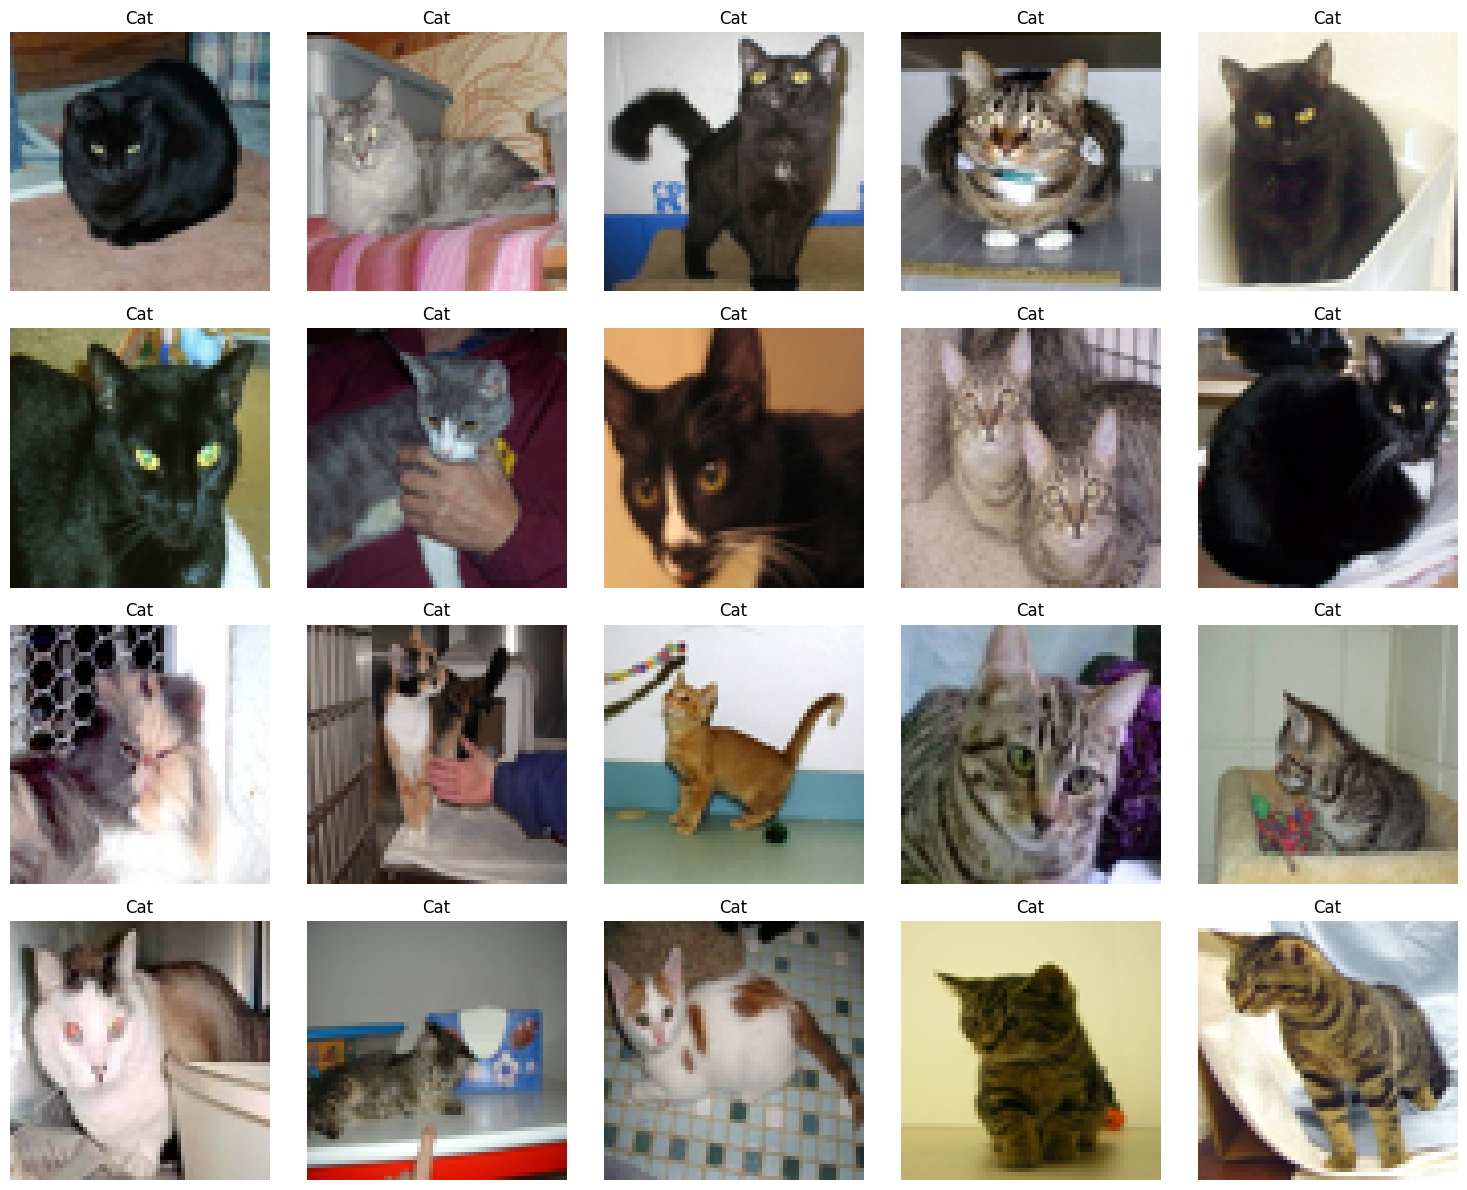

In [9]:
cat_images, cat_labels = load_images(train_dir, sample_count=20, label_filter='cat')
visualize_images(cat_images, cat_labels, sample_count=20)

## Images of Dogs in dataset
Next, we load 20 images of dogs from the training directory using the `load_images` function. Similar to the previous step, we visualize these images along with their labels using the `visualize_images` function. The labels are filtered to only include 'dog' images.


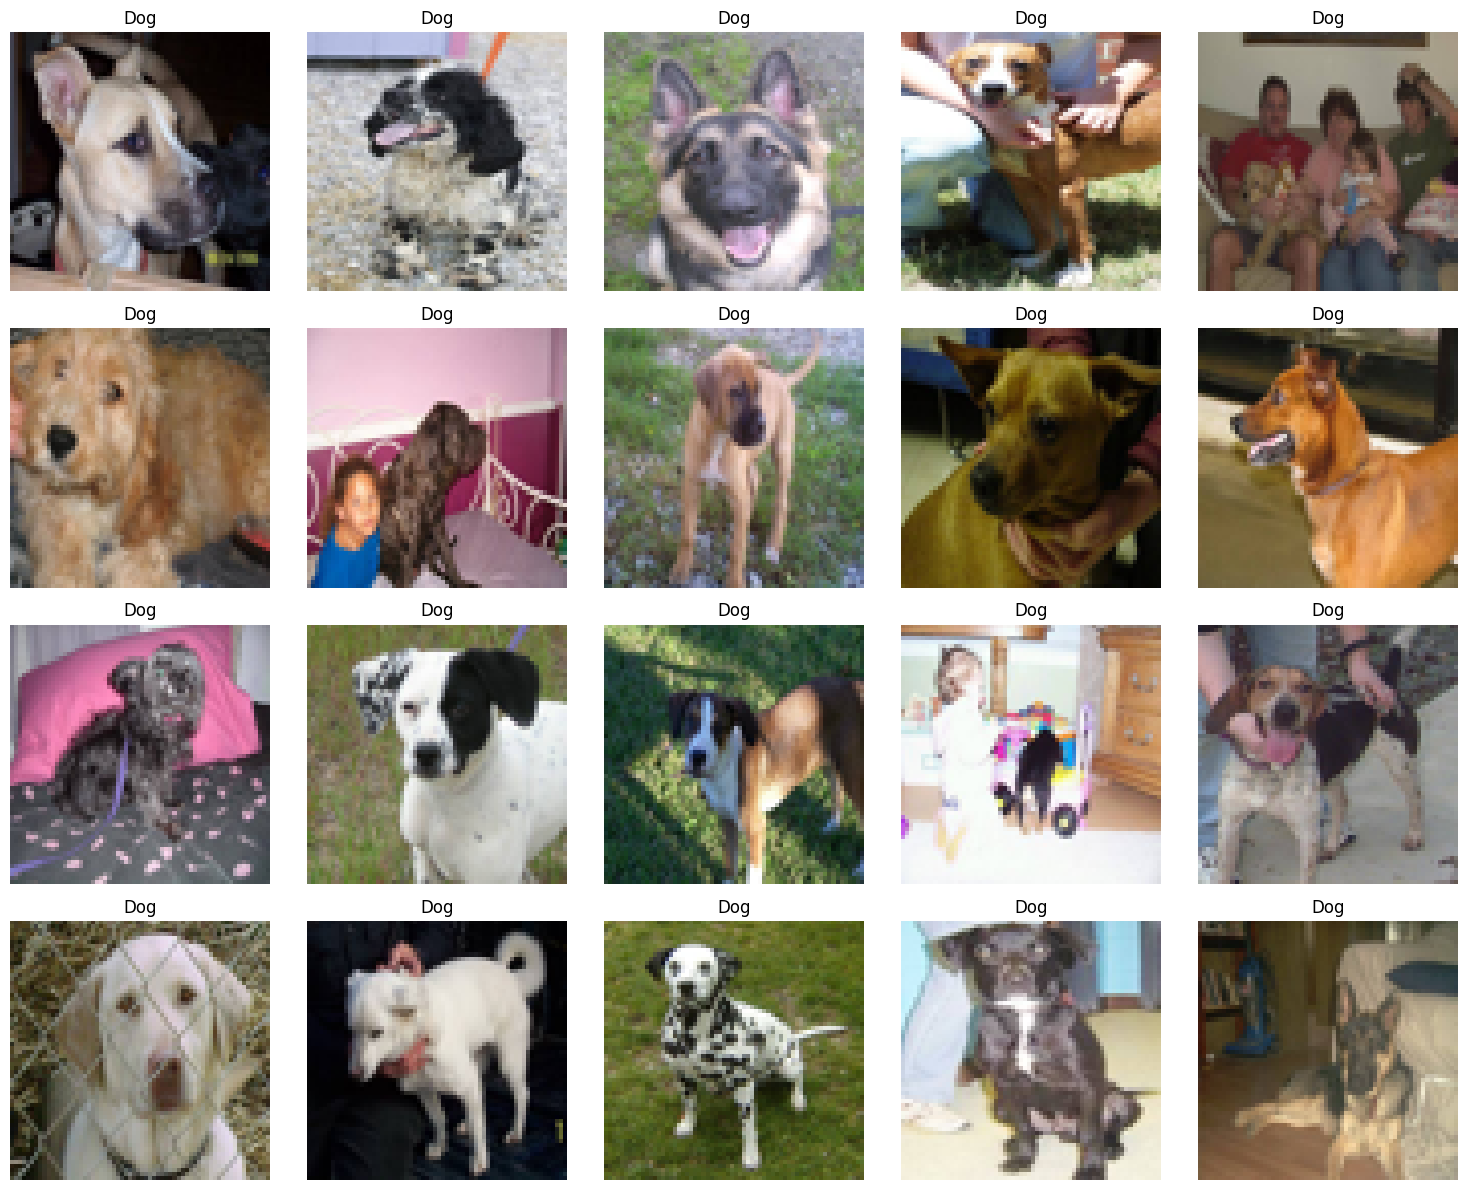

In [10]:
dog_images, dog_labels = load_images(train_dir, sample_count=20, label_filter='dog')
visualize_images(dog_images, dog_labels, sample_count=20)

## Random images from dataset
In this step, we load 20 images from the training directory without filtering by label. We use the `visualize_images` function to display these images and their corresponding labels. This allows us to view a mix of both 'cat' and 'dog' images.


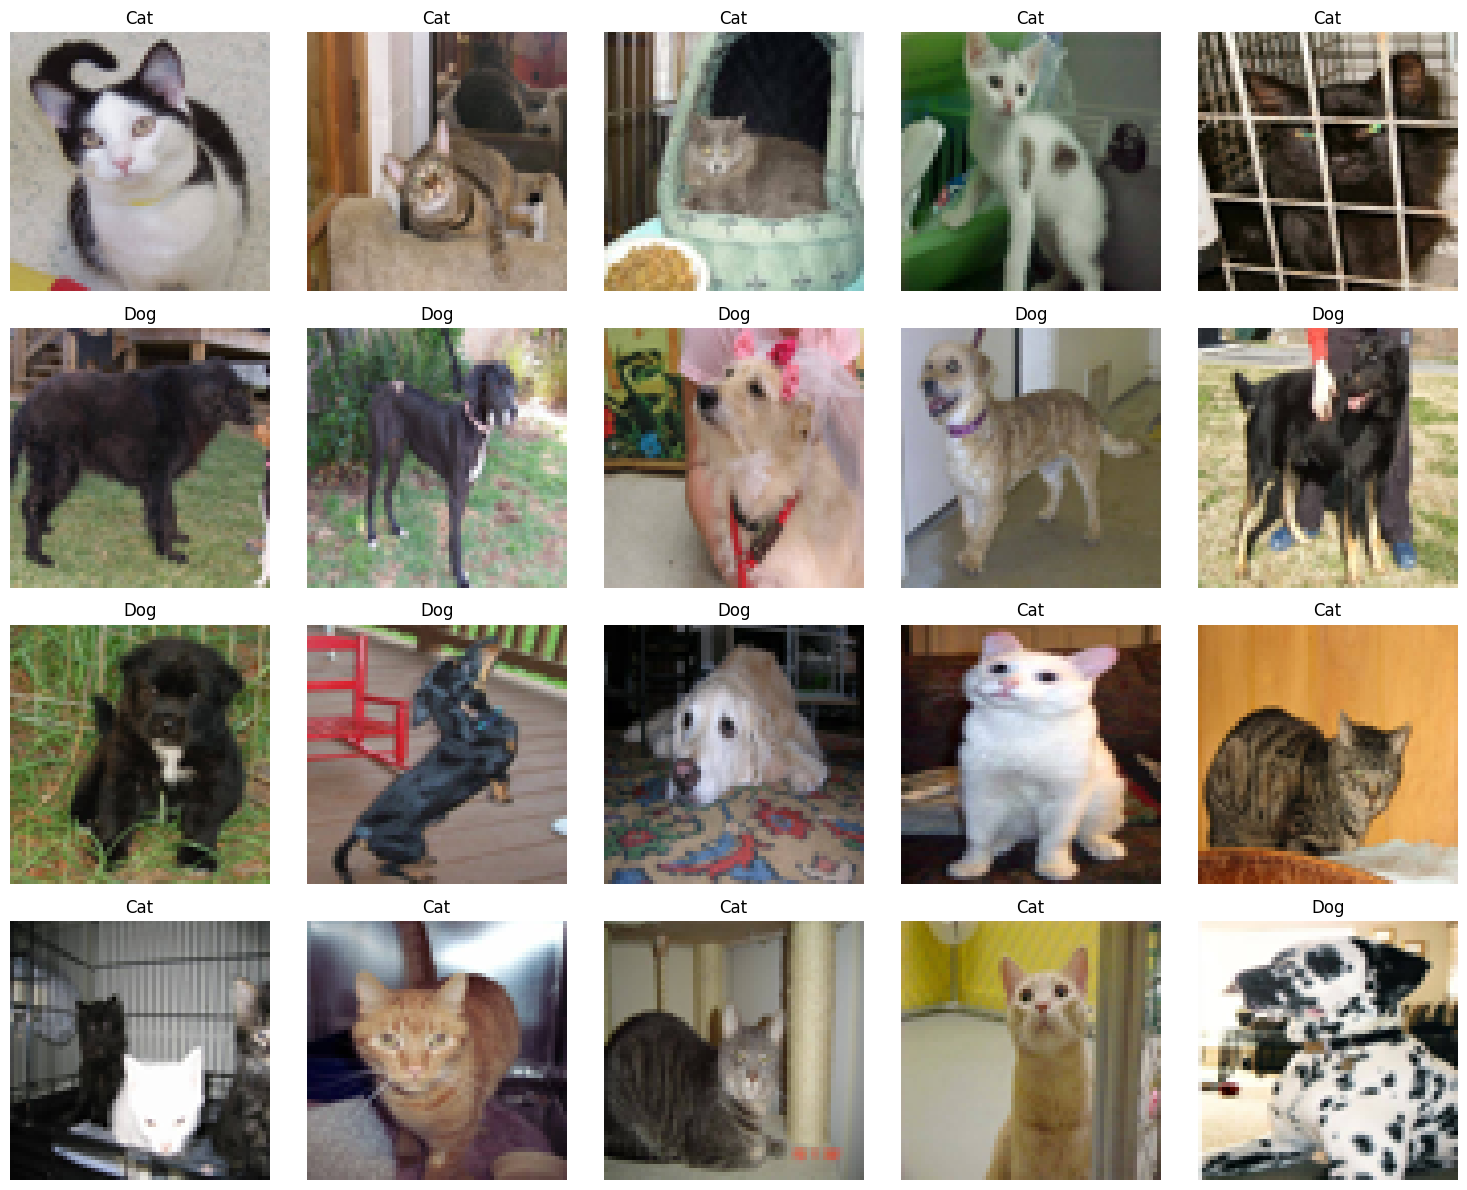

In [11]:
all_images, all_labels = load_images(train_dir, sample_count=20)
visualize_images(all_images, all_labels, sample_count=20)

## Normalizing the dataset
In this step, we load 10,000 images from the training directory. After loading, we normalize the pixel values of the images to the range [0, 1] by dividing by 255. This normalization helps in standardizing the input data for better model performance.


In [12]:
images, labels = load_images(train_dir, sample_count=10000)
images = images / 255.0

## Shape of dataset
To understand the dimensions of the image dataset, we print the shape of the `images` array. This provides insight into the number of images and their dimensions.


In [13]:
print("Shape of images array:", images.shape)

Shape of images array: (10000, 64, 64, 3)


To check the dimensions of the individual images in the dataset, we print the shape of the first image. This helps us understand the size and format of the images used in the dataset.


In [14]:
print("Shape of the first image:", images[0].shape)

Shape of the first image: (64, 64, 3)


To examine the first few entries in our dataset, we print out the first two images and their corresponding labels. This allows us to inspect the raw pixel data and verify the associated labels.


In [15]:
print(images[:2])
print(labels[:2])

[[[[0.00153787 0.00161476 0.00126105]
   [0.00135333 0.0014456  0.00112265]
   [0.00032295 0.00041522 0.00023068]
   ...
   [0.00055363 0.0007228  0.00056901]
   [0.00044598 0.00066128 0.00044598]
   [0.00046136 0.00064591 0.00047674]]

  [[0.00130719 0.0013687  0.00107651]
   [0.00156863 0.0016609  0.00127643]
   [0.00067666 0.00078431 0.00053825]
   ...
   [0.00070742 0.00090734 0.00073818]
   [0.00056901 0.00076894 0.00055363]
   [0.00038447 0.00059977 0.00038447]]

  [[0.0009381  0.00099962 0.00075356]
   [0.0013687  0.0014456  0.00104575]
   [0.00083045 0.00092272 0.00064591]
   ...
   [0.00044598 0.00067666 0.0005075 ]
   [0.0002922  0.00052288 0.00032295]
   [0.00046136 0.00069204 0.0005075 ]]

  ...

  [[0.00306036 0.00316801 0.00292195]
   [0.00307574 0.00318339 0.00292195]
   [0.00307574 0.00318339 0.00292195]
   ...
   [0.00296809 0.00326028 0.00329104]
   [0.0028143  0.00309112 0.00312188]
   [0.00278354 0.0030296  0.00306036]]

  [[0.00292195 0.0030296  0.00278354]
   [0.0

## Flattening images
We need to flatten the images for processing with machine learning algorithms. To do this, we reshape the images from their original dimensions into a flat array of pixel values. 


In [16]:
n_samples, img_height, img_width, img_channels = images.shape
images_flat = images.reshape(n_samples, -1)

## Standardized images
To standardize the feature values for our machine learning model, we use the `StandardScaler` from scikit-learn. This process will scale the pixel values to have zero mean and unit variance.


In [17]:
scaler = StandardScaler()
images_flat_scaled = scaler.fit_transform(images_flat)

We use t-Distributed Stochastic Neighbor Embedding (t-SNE) to reduce the dimensionality of our image data for visualization. This technique helps in visualizing high-dimensional data by projecting it into a 2D space.


In [18]:
perplexity = min(30, n_samples - 1)
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
images_tsne = tsne.fit_transform(images_flat_scaled)

## Splitting data into train & validation
We split our data into training and validation sets using `train_test_split`. This allows us to train our model on one subset of the data and evaluate its performance on a separate subset.


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(images_flat_scaled, labels, test_size=0.2, random_state=42)

## Checking the distribution of dataset
We check the distribution of classes in our dataset to understand how balanced it is. This step is crucial for ensuring that the model does not become biased toward one class due to imbalanced data.


In [ ]:
unique, counts = np.unique(labels, return_counts=True)
print(f"Class distribution: {dict(zip(unique, counts))}")

Class distribution: {0: 4950, 1: 5050}


## Used t-SNE to visualize data
In this cell, we visualize the t-SNE results using a scatter plot to explore the distribution of images in the reduced 2D space. This helps us understand how well the model's features separate the two classes.


In [ ]:
def plot_tsne_data(tsne_data, labels, title):
    df_tsne = pd.DataFrame()
    df_tsne['X'] = tsne_data[:, 0]
    df_tsne['Y'] = tsne_data[:, 1]
    df_tsne['Label'] = labels
    df_tsne['Label'] = df_tsne['Label'].map({0: 'Cat', 1: 'Dog'})

    fig = px.scatter(df_tsne, x='X', y='Y', color='Label', title=title)
    fig.show()

plot_tsne_data(images_tsne, labels, 't-SNE visualization of Cats vs Dogs')

## Trained SVM model
In this cell, we train a Support Vector Machine (SVM) classifier with a linear kernel on the training dataset.


In [ ]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

SVC(kernel='linear')

In this cell, we make predictions on the validation set using the trained SVM model.


In [ ]:
y_val_pred = svm.predict(X_val)

## Validating SVM model's performance
In this cell, we evaluate the performance of the SVM model on the validation set by calculating various metrics.


In [ ]:
val_accuracy = accuracy_score(y_val, y_val_pred)
val_class_report = classification_report(y_val, y_val_pred, target_names=['Cat', 'Dog'])
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

In this cell, we print the validation accuracy of the SVM model.


In [ ]:
print(f'Validation Accuracy: {val_accuracy:.4f}')

Validation Accuracy: 0.5400


In this cell, we print the classification report for the validation set.


In [ ]:
print('Validation Classification Report:')
print(val_class_report)

Validation Classification Report:
              precision    recall  f1-score   support

         Cat       0.54      0.56      0.55       998
         Dog       0.54      0.52      0.53      1002

    accuracy                           0.54      2000
   macro avg       0.54      0.54      0.54      2000
weighted avg       0.54      0.54      0.54      2000



In this cell, we visualize the confusion matrix for the validation set using a heatmap.


Validation Confusion Matrix:
[[562 436]
 [484 518]]


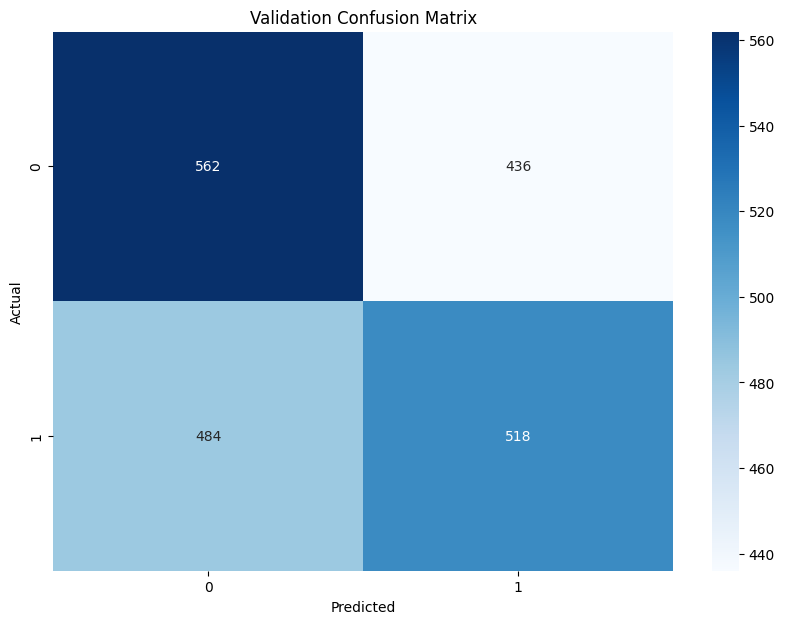

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
print('Validation Confusion Matrix:')
print(val_conf_matrix)
plt.figure(figsize=(10, 7))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Validation Confusion Matrix')
plt.show()


## Training CNN model
In this cell, we build and train a Convolutional Neural Network (CNN) to classify images of cats and dogs. The model includes data loading, preprocessing, and evaluation.


In [6]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image

# Parameters
img_height, img_width, img_channels = 64, 64, 3  # Adjusted for color images
INPUT_SHAPE = (img_height, img_width, img_channels)
KERNEL_SIZE = (3, 3)
batch_size = 32

# Paths
train_dir = '/kaggle/working/train/train'
test_dir = '/kaggle/working/test/test1'

def load_images(folder, img_size=(64, 64), label_filter=None):
    images = []
    labels = []
    filenames = os.listdir(folder)

    if label_filter is not None:
        filenames = [fname for fname in filenames if label_filter in fname]

    random.shuffle(filenames)
    for img in filenames:
        try:
            img_path = os.path.join(folder, img)
            img_pil = Image.open(img_path)
            img_pil = img_pil.resize(img_size)
            img_np = np.array(img_pil) / 255.0  # Normalize pixel values
            images.append(img_np)
            labels.append(0 if 'cat' in img else 1)
        except Exception as e:
            print(f"Error loading image {img}: {e}")

    return np.array(images), np.array(labels)

# Load data
cat_images, cat_labels = load_images(train_dir, label_filter='cat')
dog_images, dog_labels = load_images(train_dir, label_filter='dog')

X = np.concatenate((cat_images, dog_images), axis=0)
y = np.concatenate((cat_labels, dog_labels), axis=0)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Convolutional Layer 2
model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Convolutional Layer 3
model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=METRICS)

# Model summary
model.summary()

# Data augmentation
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(X_train, y_train, batch_size=batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

# Fit the model
r = model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_val, y_val)
)

# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                        

## Saving the CNN model
In this cell, we save the model architecture and weights to files, and use pickle to store the file paths.


In [9]:
# Save the model architecture to JSON
import json
import pickle

model_json = model.to_json()
with open("model_architecture.json", "w") as json_file:
    json.dump(model_json, json_file)

# Save the model weights to HDF5
model.save_weights("model_weights.h5")

# Use pickle to save the paths to the architecture and weights files
model_paths = {
    "architecture": "model_architecture.json",
    "weights": "model_weights.h5"
}

with open("model_paths.pkl", "wb") as f:
    pickle.dump(model_paths, f)

print("Model saved using pickle")

Model saved using pickle


In this cell, we save the entire trained model using pickle for future use.


In [10]:
import pickle

# Save the model using pickle
with open('cats_vs_dogs_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model saved using pickle")


Model saved using pickle


## Making prediction using CNN model on downloaded image
In this cell, we load the previously saved model and use it to make predictions on new images.


In [13]:
import pickle
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Load the saved model
with open('cats_vs_dogs_model.pkl', 'rb') as file:
    model = pickle.load(file)

# Function to preprocess the image
def preprocess_image(image_path, img_size=(64, 64)):
    # Load the image
    img = load_img(image_path, target_size=img_size)
    # Convert the image to an array
    img_array = img_to_array(img)
    # Normalize the image
    img_array = img_array / 255.0
    # Expand dimensions to match the input shape of the model
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to make predictions
def make_prediction(image_path):
    # Preprocess the image
    processed_image = preprocess_image(image_path)
    # Make prediction
    prediction = model.predict(processed_image)
    # Determine if the image is of a cat or a dog
    if prediction[0][0] > 0.5:
        result = 'Dog'
    else:
        result = 'Cat'
    return result

# Example usage
image_path = '/content/download.jpeg'  # Replace with the path to your image
result = make_prediction(image_path)
print(f'The image is predicted to be a: {result}')


1/1 [==============================] - 0s 137ms/step
The image is predicted to be a: Cat
